
CS6220 Final Project - Weather Pattern Classification
Author: Hanru Chen
Date: April 2025

This script performs weather pattern classification on the NOAA dataset using 
K-means clustering with PCA dimensionality reduction. The goal is to identify 
distinct weather patterns such as "Hot and Dry," "Cold and Snowy," etc.

Input: cleaned_weather.csv (preprocessed weather data)
Output: 
- Visualizations of weather patterns
- Saved cluster model and profiles
- Summary of identified weather patterns


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.cm as cm
import warnings
from joblib import dump



In [4]:
# 1. Load and Explore Data

print("\n" + "-"*50)
print("WEATHER PATTERN CLASSIFICATION - NOAA DATASET")
print("-"*50)

# Load the cleaned weather data
print("\nFirstly, loading and exploring the cleaned weather data")
weather_df = pd.read_csv('cleaned_weather.csv')

# Display basic information about the dataset
print(f"Dataset appearance: {weather_df.shape[0]} rows, {weather_df.shape[1]} columns")
print("\nSample of first 5 records:")
print(weather_df.head())

# Check for missing values in key weather attributes
weather_features = ['TMIN', 'TMAX', 'TAVG', 'AWND', 'WSF5', 'SNOW', 'SNWD', 'PRCP']
missing_values = weather_df[weather_features].isnull().sum()
print("\nMissing values in weather attributes:")
print(missing_values)

# Display summary statistics for weather attributes
print("\nSummary statistics for weather attributes:")
print(weather_df[weather_features].describe().round(2))


--------------------------------------------------
WEATHER PATTERN CLASSIFICATION - NOAA DATASET
--------------------------------------------------

Firstly, loading and exploring the cleaned weather data
Dataset appearance: 71978 rows, 15 columns

Sample of first 5 records:
                station state  latitude  longitude  elevation        date  \
0          GUAM INTL AP    GU   13.4836   144.7961       77.4  2017-03-12   
1  KALISPELL GLACIER AP    MT   48.3042  -114.2636      901.3  2017-02-07   
2  KALISPELL GLACIER AP    MT   48.3042  -114.2636      901.3  2017-03-30   
3  KALISPELL GLACIER AP    MT   48.3042  -114.2636      901.3  2017-06-22   
4  KALISPELL GLACIER AP    MT   48.3042  -114.2636      901.3  2017-07-25   

    TMIN   TMAX   TAVG      AWND   WDF5       WSF5     SNOW       SNWD  \
0  71.06  87.08  80.06  4.473880  360.0  21.027236  0.00000   0.000000   
1  -0.76  22.10  13.64  3.802798  360.0  14.092722  0.11811  22.047256   
2  37.04  53.96  44.24  4.026492  360.

In [5]:
# 2. Data Preprocessing

print("Preprocessing data for clustering")

# Select features for clustering 
# Exclude SNOW and SNWD due to higher missing values as shown in our analysis
# SNOW: missing values in 6843 rows which is about 9.51% of the dataset
# SNWD: missing values in 7127 rows which is about 9.9% of the dataset
# We need to avoid features with high missing values for clustering due to the bias they can introduce
selected_features = ['TMIN', 'TMAX', 'TAVG', 'AWND', 'WSF5', 'PRCP']
print(f"Selected features for clustering: {selected_features}")

# Create dataset with complete cases for the selected features
complete_df = weather_df.dropna(subset=selected_features).reset_index(drop=True)
print(f"Complete cases for analysis: {complete_df.shape[0]} out of {weather_df.shape[0]} rows")


Preprocessing data for clustering
Selected features for clustering: ['TMIN', 'TMAX', 'TAVG', 'AWND', 'WSF5', 'PRCP']
Complete cases for analysis: 71978 out of 71978 rows



Analyze feature correlations

Correlation Matrix:
      TMIN  TMAX  TAVG  AWND  WSF5  PRCP
TMIN  1.00  0.90  0.97 -0.08  0.01  0.10
TMAX  0.90  1.00  0.97 -0.14  0.01  0.00
TAVG  0.97  0.97  1.00 -0.10  0.03  0.06
AWND -0.08 -0.14 -0.10  1.00  0.75  0.08
WSF5  0.01  0.01  0.03  0.75  1.00  0.20
PRCP  0.10  0.00  0.06  0.08  0.20  1.00


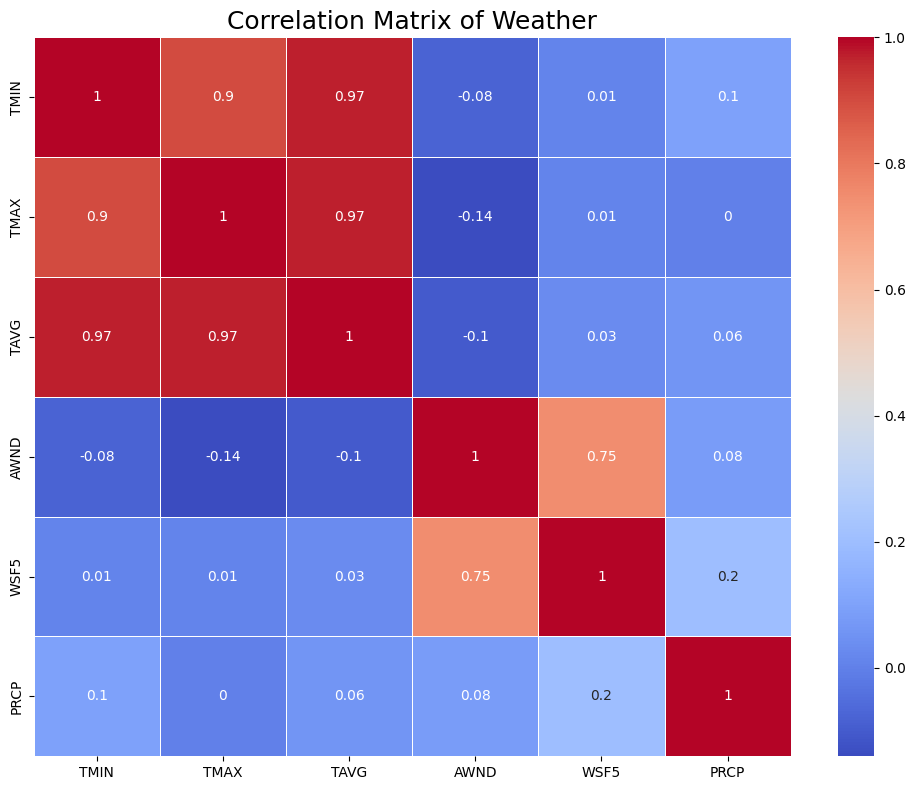

In [6]:
# 3. Correlation Analysis

print("\nAnalyze feature correlations")

# Calculate and display correlation matrix
corr_matrix = complete_df[selected_features].corr().round(2)
print("\nCorrelation Matrix:")
print(corr_matrix)

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Weather', fontsize=18)
plt.tight_layout()
plt.savefig('weather_correlation_heatmap.png', dpi=300)
plt.show()



Standardizing the data for PCA analysis
Performing Principal Component Analysis (PCA)

Variance explained by each principal component:
PC1: 0.4854 (Cumulative: 0.4854)
PC2: 0.2994 (Cumulative: 0.7848)
PC3: 0.1595 (Cumulative: 0.9443)
PC4: 0.0402 (Cumulative: 0.9845)
PC5: 0.0141 (Cumulative: 0.9985)
PC6: 0.0015 (Cumulative: 1.0000)


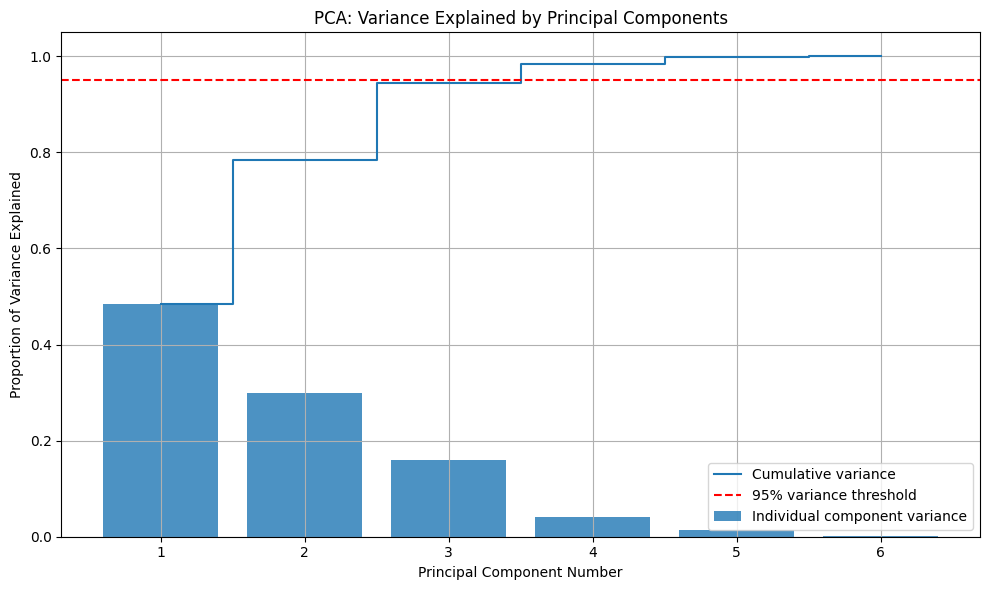


Feature loadings on principal components:
        PC1    PC2    PC3    PC4    PC5    PC6
TMIN  0.568  0.058  0.012 -0.232 -0.675 -0.405
TMAX  0.570  0.021 -0.088  0.163  0.679 -0.424
TAVG  0.582  0.053 -0.043 -0.023  0.016  0.810
AWND -0.106  0.667 -0.243 -0.668  0.195 -0.004
WSF5 -0.023  0.697 -0.106  0.683 -0.189 -0.012
PRCP  0.041  0.250  0.959 -0.077  0.100  0.000

Feature loadings heatmap saved as 'pca_feature_loadings.png'


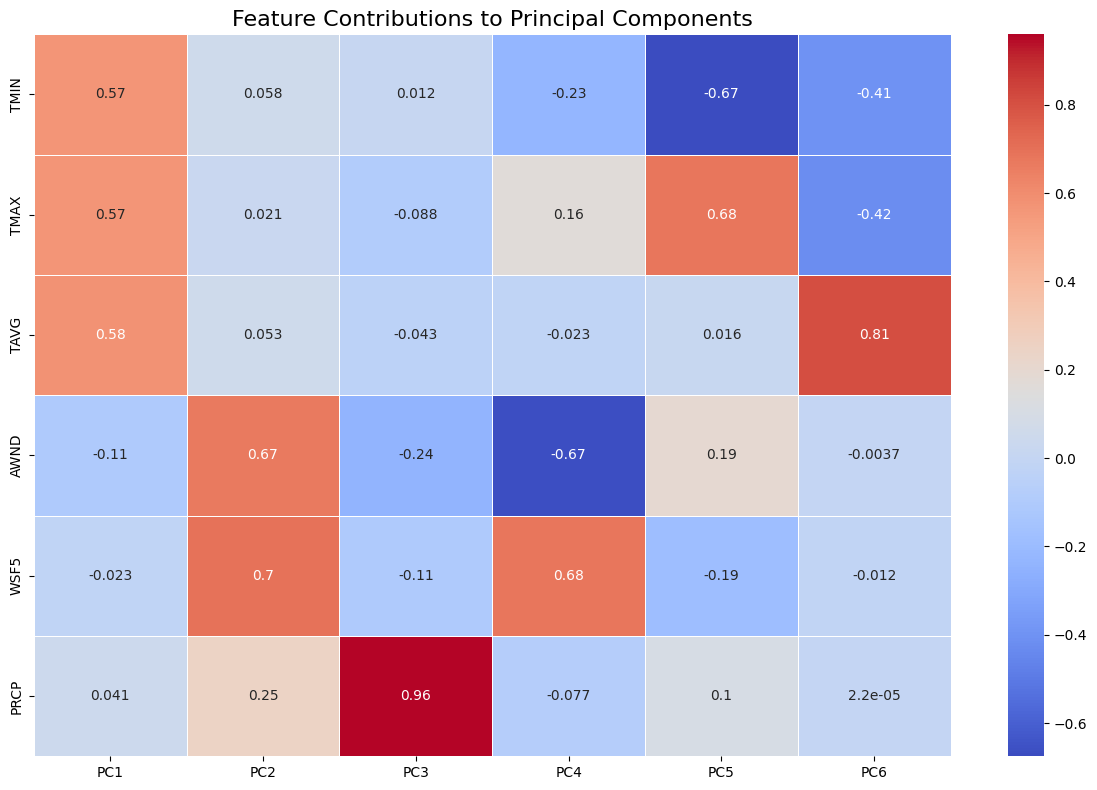


Optimal number of principal components: 3
These components capture 94.43% of total variance
Dimensionally reduced data shape: (71978, 3)


In [7]:
# 4. Principal Component Analysis (PCA)

# Standardize the data (required for PCA to work properly)
print("\nStandardizing the data for PCA analysis")
featureScaler = StandardScaler()  # Create standardization object
standardizedFeatures = featureScaler.fit_transform(complete_df[selected_features])  # Apply standardization

# Apply Principal Component Analysis to standardized data
print("Performing Principal Component Analysis (PCA)")
principalComponentModel = PCA()  # Initialize PCA model
transformedData = principalComponentModel.fit_transform(standardizedFeatures)  # Transform data to PC

# Calculate and display variance 
varianceRatio = principalComponentModel.explained_variance_ratio_  # Get variance explained by each PC
cumulativeVariance = np.cumsum(varianceRatio)  # Calculate cumulative variance explained
print("\nVariance explained by each principal component:")
for componentIndex, varianceValue in enumerate(varianceRatio):
    print(f"PC{componentIndex+1}: {varianceValue:.4f} (Cumulative: {cumulativeVariance[componentIndex]:.4f})")

# Visualize the variance explained by principal components
plt.figure(figsize=(10, 6))
# Plot individual variance bars
plt.bar(range(1, len(varianceRatio) + 1), varianceRatio, alpha=0.8, 
        label='Individual component variance')
# Plot cumulative variance line
plt.step(range(1, len(cumulativeVariance) + 1), cumulativeVariance, where='mid', 
         label='Cumulative variance')
# Add reference line for 95% threshold
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance threshold')
plt.xlabel('Principal Component Number')
plt.ylabel('Proportion of Variance Explained')
plt.title('PCA: Variance Explained by Principal Components')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('pca_variance_analysis.png', dpi=300)
plt.show()

# Extract feature loadings (shows contribution of original features to each PC)
featureLoadings = pd.DataFrame(
    principalComponentModel.components_.T,  # Transpose to get features as rows, PCs as columns
    columns=[f'PC{i+1}' for i in range(len(selected_features))],
    index=selected_features
)
print("\nFeature loadings on principal components:")
print(featureLoadings.round(3))

# Visualize feature loadings with a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(featureLoadings, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Contributions to Principal Components', fontsize=16)
plt.tight_layout()
plt.savefig('pca_feature_loadings.png', dpi=300)
print("\nFeature loadings heatmap saved as 'pca_feature_loadings.png'")
plt.show()

# Determine optimal number of components based on explained variance threshold
# Select the minimum number of components needed to explain at least 90% of variance
optimalComponentCount = np.argmax(cumulativeVariance >= 0.9) + 1  # +1 since indices start at 0
print(f"\nOptimal number of principal components: {optimalComponentCount}")
print(f"These components capture {cumulativeVariance[optimalComponentCount-1]:.2%} of total variance")

# Create reduced PCA model with optimal number of components
optimizedPcaModel = PCA(n_components=optimalComponentCount)  # Create PCA with optimal components
reducedFeatureData = optimizedPcaModel.fit_transform(standardizedFeatures)  # Transform data
print(f"Dimensionally reduced data shape: {reducedFeatureData.shape}")


Determining optimal number of clusters (k) using Elbow Method and Silhouette Score
K=2: Inertia=265217.77, Silhouette Score=0.3815
K=3: Inertia=207798.74, Silhouette Score=0.3651
K=4: Inertia=173093.69, Silhouette Score=0.3681
K=5: Inertia=146096.33, Silhouette Score=0.3257
K=6: Inertia=123876.06, Silhouette Score=0.3239
K=7: Inertia=113628.96, Silhouette Score=0.3274
K=8: Inertia=103737.18, Silhouette Score=0.2871
K=9: Inertia=94038.00, Silhouette Score=0.3137
K=10: Inertia=86085.14, Silhouette Score=0.2939

Optimal k determination plot saved as 'optimal_k_determination.png'


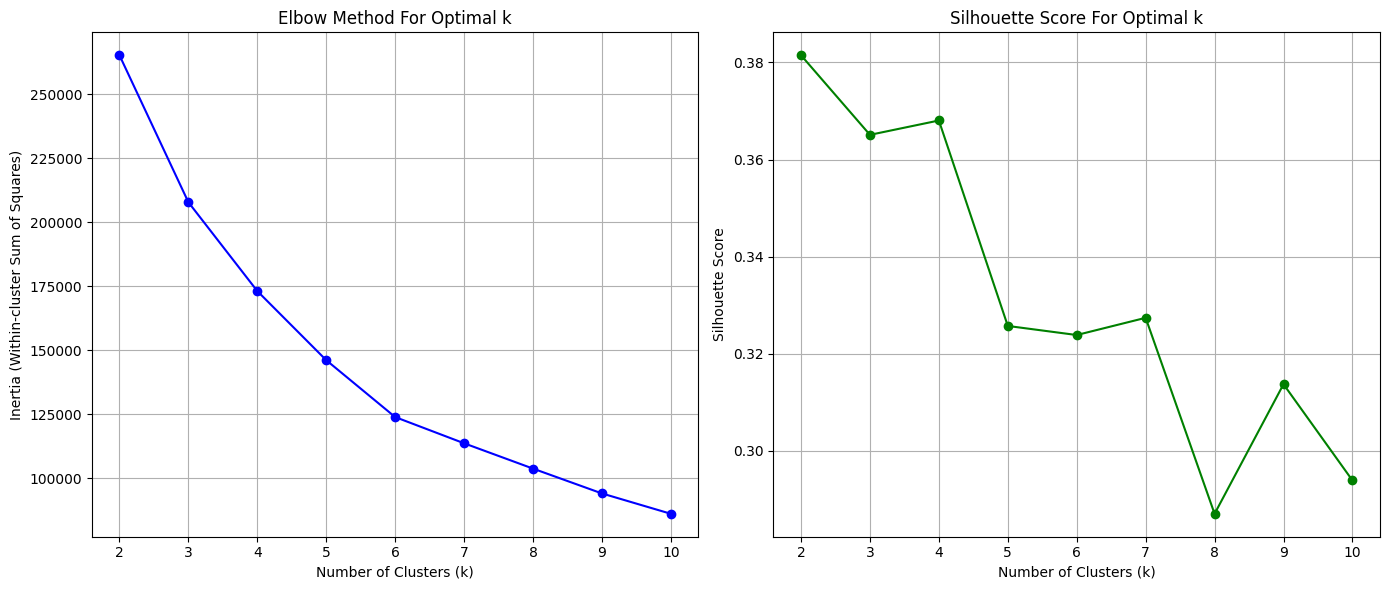

In [8]:
# 5. Determine Optimal Number of Clusters (K)

# Identifies the ideal number of clusters
# Using two methods: the Elbow Method and Silhouette Score

# Set the maximum number of clusters to evaluate
max_k = 10 # test from 2 to 10 clusters
inertia = [] # store within-cluster sum of squares for each k
silhouette_scores = [] # store silhouette scores for each k

print("\nDetermining optimal number of clusters (k) using Elbow Method and Silhouette Score")
# evaluate from k=2 to k=max_k 
for k in range(2, max_k + 1):
    # create and fit in k-means model 
    # using random_state=42 for reproducibility, n_init=10 for multiple initializations
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(reducedFeatureData)

    # WCSS (inertia) is the sum of squared distances to the nearest cluster center
    # lower inertia indicates better clustering
    inertia.append(kmeans.inertia_)
    
    # Calculate silhouette score
    # values range from -1 to 1, where higher values indicate better-defined clusters
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(reducedFeatureData, labels)
    silhouette_scores.append(silhouette_avg)
    
    print(f"K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette Score={silhouette_avg:.4f}")

# Plot Elbow Method and Silhouette Score
plt.figure(figsize=(14, 6))

# elbow method plot
plt.subplot(1, 2, 1)
plt.plot(range(2, max_k + 1), inertia, 'o-', color='blue')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-cluster Sum of Squares)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)

# silhourette score plot - higher values indicate better-defined clusters
plt.subplot(1, 2, 2)
plt.plot(range(2, max_k + 1), silhouette_scores, 'o-', color='green')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.grid(True)

plt.tight_layout()  #  be sure to have proper spacing between subplots
plt.savefig('optimal_k_determination.png')
print("\nOptimal k determination plot saved as 'optimal_k_determination.png'")
plt.show()

# Determine optimal K based on silhouette score and elbow method
optimal_k = np.argmax(silhouette_scores) + 2  # +2 because start from k=2

In [9]:
# 6. K-means Clustering with Optimal K

# Apply K-means with optimal K
print(f"\nPerforming K-means clustering with {optimal_k} clusters")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10) # Initialize model with optimal k
cluster_labels = kmeans.fit_predict(reducedFeatureData) # fit the model and get cluster labels

# Add cluster labels to the dataframe
complete_df['cluster'] = cluster_labels
complete_df['cluster_name'] = [f'Cluster {i+1}' for i in cluster_labels]

# Get the coordinates of the cluster centers in PCA
centers = kmeans.cluster_centers_ # (optimal_k, n_components)


Performing K-means clustering with 2 clusters


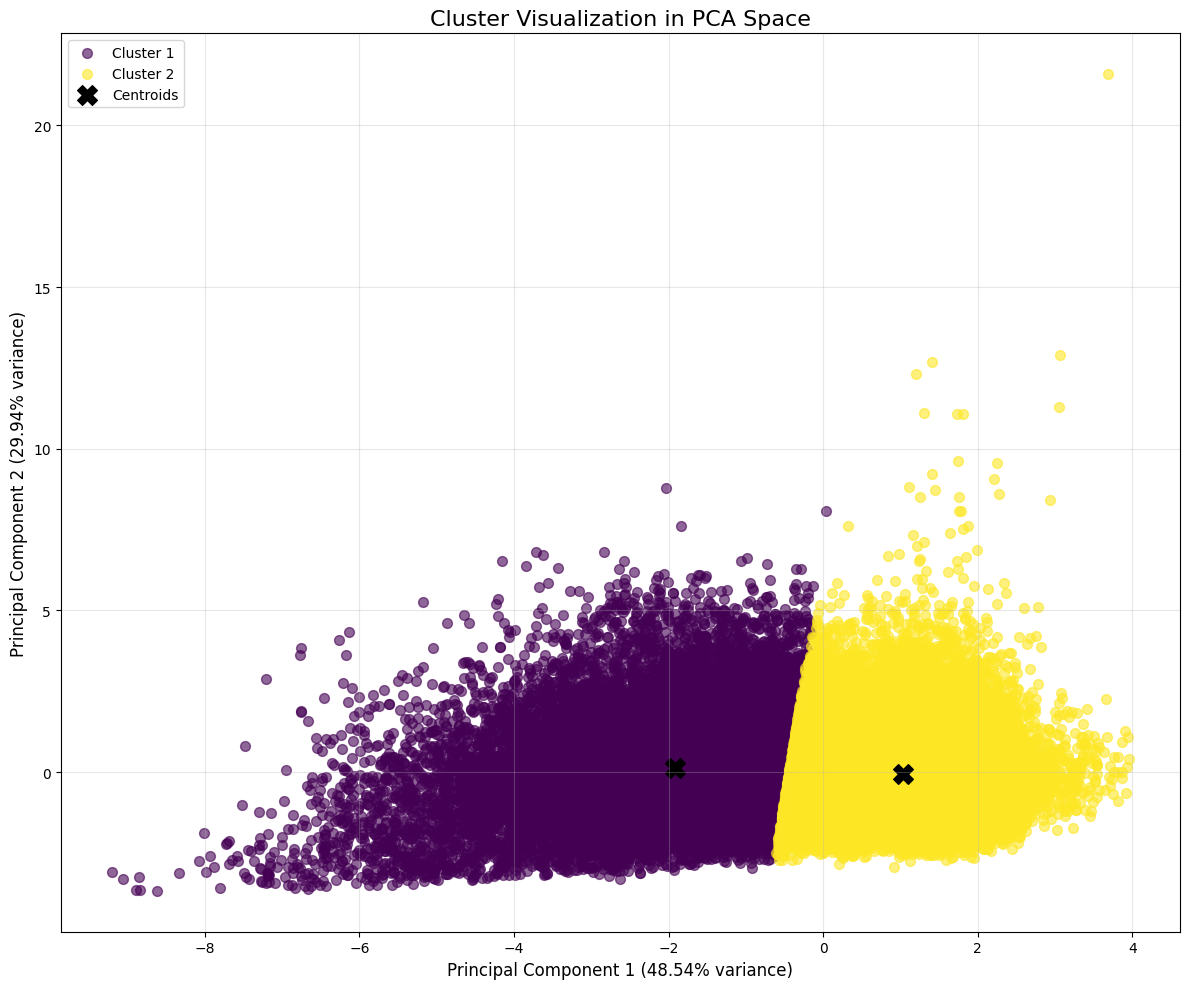

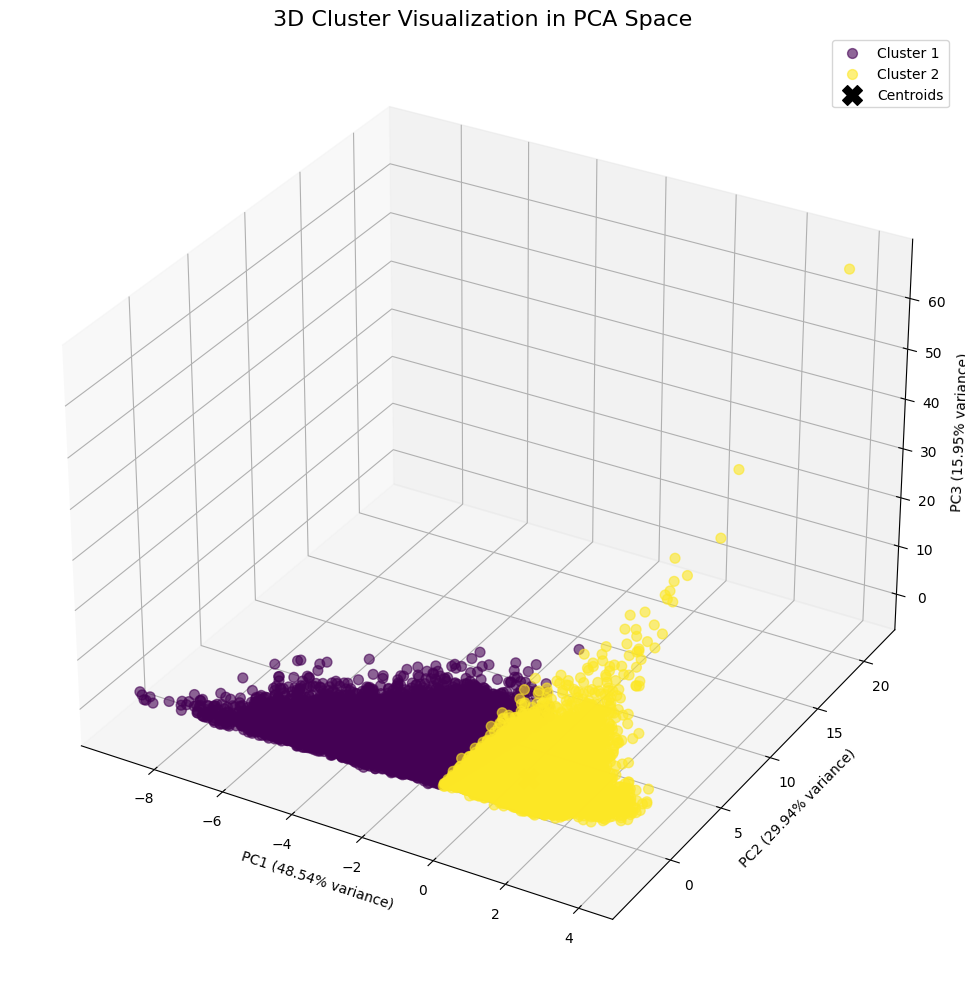

In [10]:
# 7. Visualize Clusters in PCA Space

# 2D Visualization by using first two principal components
# capture the most variance in the data
plt.figure(figsize=(12, 10))

# Create a scatter plot for each cluster
unique_labels = np.unique(cluster_labels) # get unique cluster labels
colors = cm.viridis(np.linspace(0, 1, len(unique_labels))) # generate colors for clusters

# Plot each cluster with a different color
for i, color in zip(unique_labels, colors):
    cluster_points = reducedFeatureData[cluster_labels == i]
    plt.scatter(
        cluster_points[:, 0], 
        cluster_points[:, 1],
        s=50, 
        c=[color], 
        label=f'Cluster {i+1}',
        alpha=0.6
    )

# Add cluster centers
plt.scatter(
    centers[:, 0], 
    centers[:, 1], 
    s=200, 
    c='black', 
    marker='X', 
    label='Centroids'
)

# Add axis labels
explained_var = optimizedPcaModel.explained_variance_ratio_
plt.xlabel(f'Principal Component 1 ({explained_var[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'Principal Component 2 ({explained_var[1]:.2%} variance)', fontsize=12)
plt.title('Cluster Visualization in PCA Space', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('clusters_2d_visualization.png')
plt.show()

# 3D Visualization for at least 3 components
# provide a more comprehensive view of the clusters
if optimalComponentCount >= 3:
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    for i, color in zip(unique_labels, colors):
        cluster_points = reducedFeatureData[cluster_labels == i]
        ax.scatter(
            cluster_points[:, 0],
            cluster_points[:, 1],
            cluster_points[:, 2],
            s=50,
            c=[color],
            label=f'Cluster {i+1}',
            alpha=0.6
        )
    
    # Add cluster centers
    ax.scatter(
        centers[:, 0],
        centers[:, 1],
        centers[:, 2],
        s=200,
        c='black',
        marker='X',
        label='Centroids'
    )
    
    # Add axis labels
    ax.set_xlabel(f'PC1 ({explained_var[0]:.2%} variance)', fontsize=10)
    ax.set_ylabel(f'PC2 ({explained_var[1]:.2%} variance)', fontsize=10)
    ax.set_zlabel(f'PC3 ({explained_var[2]:.2%} variance)', fontsize=10)
    ax.set_title('3D Cluster Visualization in PCA Space', fontsize=16)
    plt.legend()
    plt.tight_layout()
    plt.savefig('clusters_3d_visualization.png')
    plt.show()


In [11]:
# 8. Transform Cluster Centers Back to Original Features
# converts the cluster centers from PCA space back to the original feature space

# reverse the pca transformation from pca space to standardized space
original_centers = optimizedPcaModel.inverse_transform(centers) # pca -> standardized
# reverse the standardization transformation from standardized space to original feature space
original_centers = featureScaler.inverse_transform(original_centers)

# Create a dataframe of cluster centers in original feature space
centers_df = pd.DataFrame(original_centers, columns=selected_features)
centers_df.index = [f'Cluster {i+1}' for i in range(len(centers_df))]
print("\nCluster centers in original feature space:")
print(centers_df.round(2))


Cluster centers in original feature space:
            TMIN   TMAX   TAVG  AWND   WSF5  PRCP
Cluster 1  27.71  46.96  37.46  9.51  26.51  0.10
Cluster 2  59.52  81.59  70.25  7.71  24.69  0.12



Cluster Profiles (Mean Values):
            TMIN   TMAX   TAVG  AWND   WSF5  PRCP
Cluster 1  28.00  46.71  37.40  9.51  26.54  0.10
Cluster 2  59.36  81.73  70.28  7.71  24.67  0.12

Cluster profiles visualization saved as 'cluster_profiles.png'


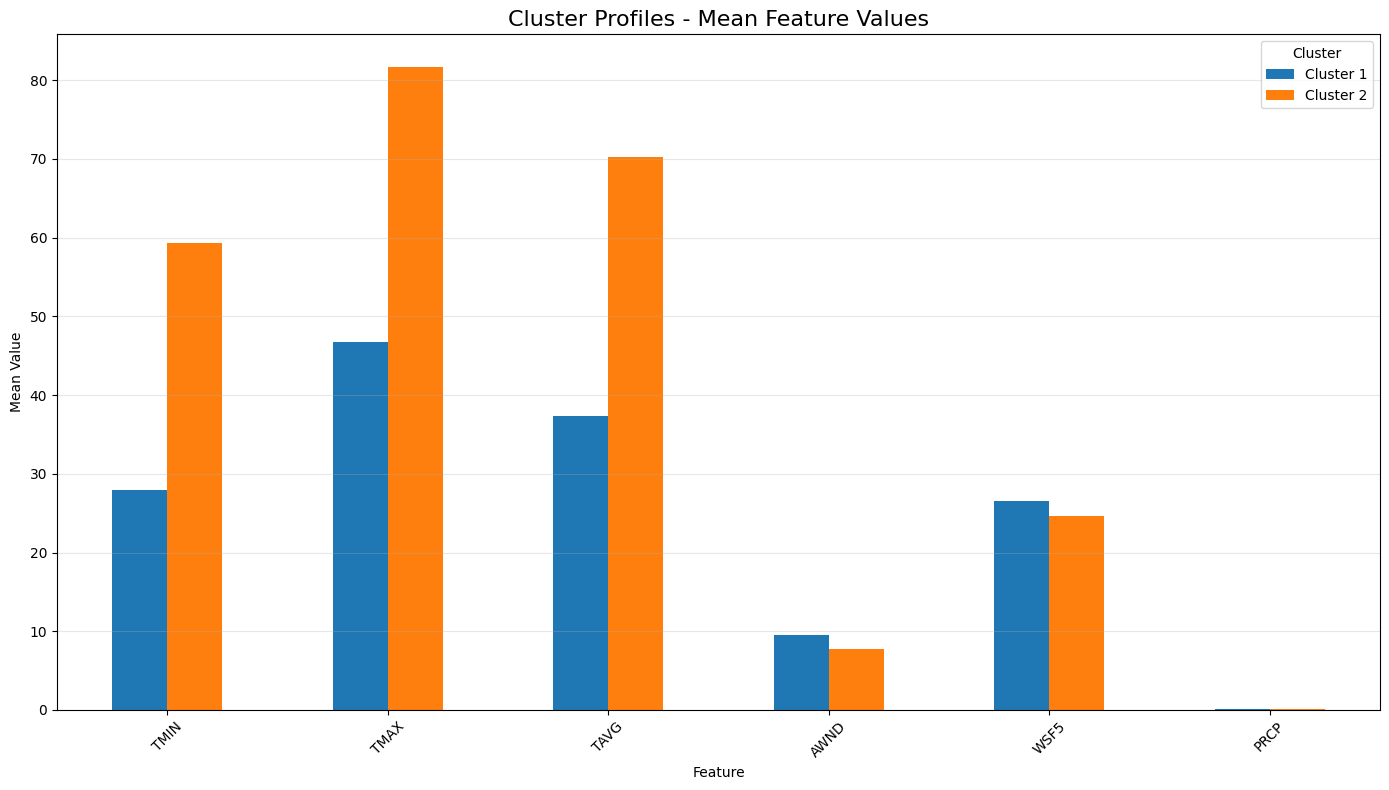


Cluster profiles heatmap saved as 'cluster_profiles_heatmap.png'


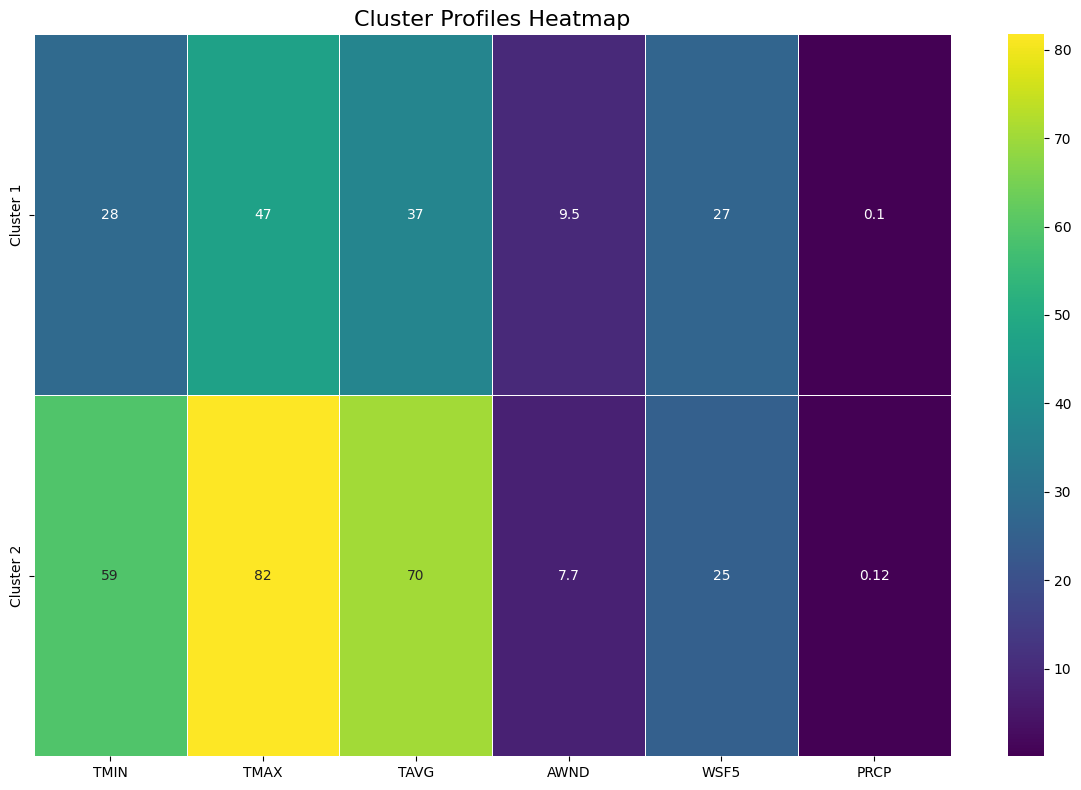


Weather Pattern Names:
Cluster 1: Cool, Breezy, Dry
Cluster 2: Warm, Breezy, Light Rain


In [12]:
# 9. Characterize and Name Clusters

# Compute feature means for each cluster
cluster_profiles = complete_df.groupby('cluster')[selected_features].mean().round(2)
cluster_profiles.index = [f'Cluster {i+1}' for i in range(len(cluster_profiles))]

print("\nCluster Profiles (Mean Values):")
print(cluster_profiles)

# Visualize cluster profiles
plt.figure(figsize=(14, 8))
cluster_profiles.T.plot(kind='bar', ax=plt.gca())
plt.title('Cluster Profiles - Mean Feature Values', fontsize=16)
plt.ylabel('Mean Value')
plt.xlabel('Feature')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('cluster_profiles.png')
print("\nCluster profiles visualization saved as 'cluster_profiles.png'")
plt.show()

# Create a heatmap of the cluster profiles
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_profiles, annot=True, cmap='viridis', linewidths=0.5)
plt.title('Cluster Profiles Heatmap', fontsize=16)
plt.tight_layout()
plt.savefig('cluster_profiles_heatmap.png')
print("\nCluster profiles heatmap saved as 'cluster_profiles_heatmap.png'")
plt.show()

# Name the clusters based on their characteristics
def name_weather_pattern(profile):
    """Assign a descriptive name to a weather pattern based on its characteristics."""
    # Define thresholds for temperature based on TMAX
    if profile['TMAX'] > 85:
        temp_label = "Hot"
    elif profile['TMAX'] > 70:
        temp_label = "Warm"
    elif profile['TMAX'] > 50:
        temp_label = "Mild"
    elif profile['TMAX'] > 32:
        temp_label = "Cool"
    else:
        temp_label = "Cold"
    
    # Define thresholds for wind based on AWND
    if profile['AWND'] > 15:
        wind_label = "Very Windy"
    elif profile['AWND'] > 10:
        wind_label = "Windy"
    elif profile['AWND'] > 5:
        wind_label = "Breezy"
    else:
        wind_label = "Calm"
    
    # Define thresholds for precipitation based on PRCP
    if profile['PRCP'] > 0.5:
        precip_label = "Rainy"
    elif profile['PRCP'] > 0.1:
        precip_label = "Light Rain"
    else:
        precip_label = "Dry"
    
    # Check for snow if SNOW is available
    if 'SNOW' in profile and profile['SNOW'] > 0.1:
        precip_label = "Snowy"
    
    return f"{temp_label}, {wind_label}, {precip_label}"

# Apply naming function to each cluster profile
pattern_names = {}
for cluster_id, profile in cluster_profiles.iterrows():
    pattern_name = name_weather_pattern(profile)
    pattern_names[cluster_id] = pattern_name

# Print the weather pattern names
print("\nWeather Pattern Names:")
for cluster_id, name in pattern_names.items():
    print(f"{cluster_id}: {name}")

# Add pattern names to the dataframe
pattern_name_mapping = {i: pattern_names[f'Cluster {i+1}'] for i in range(len(pattern_names))}
complete_df['pattern_name'] = complete_df['cluster'].map(pattern_name_mapping)



Analyzing geographical distribution of weather patterns


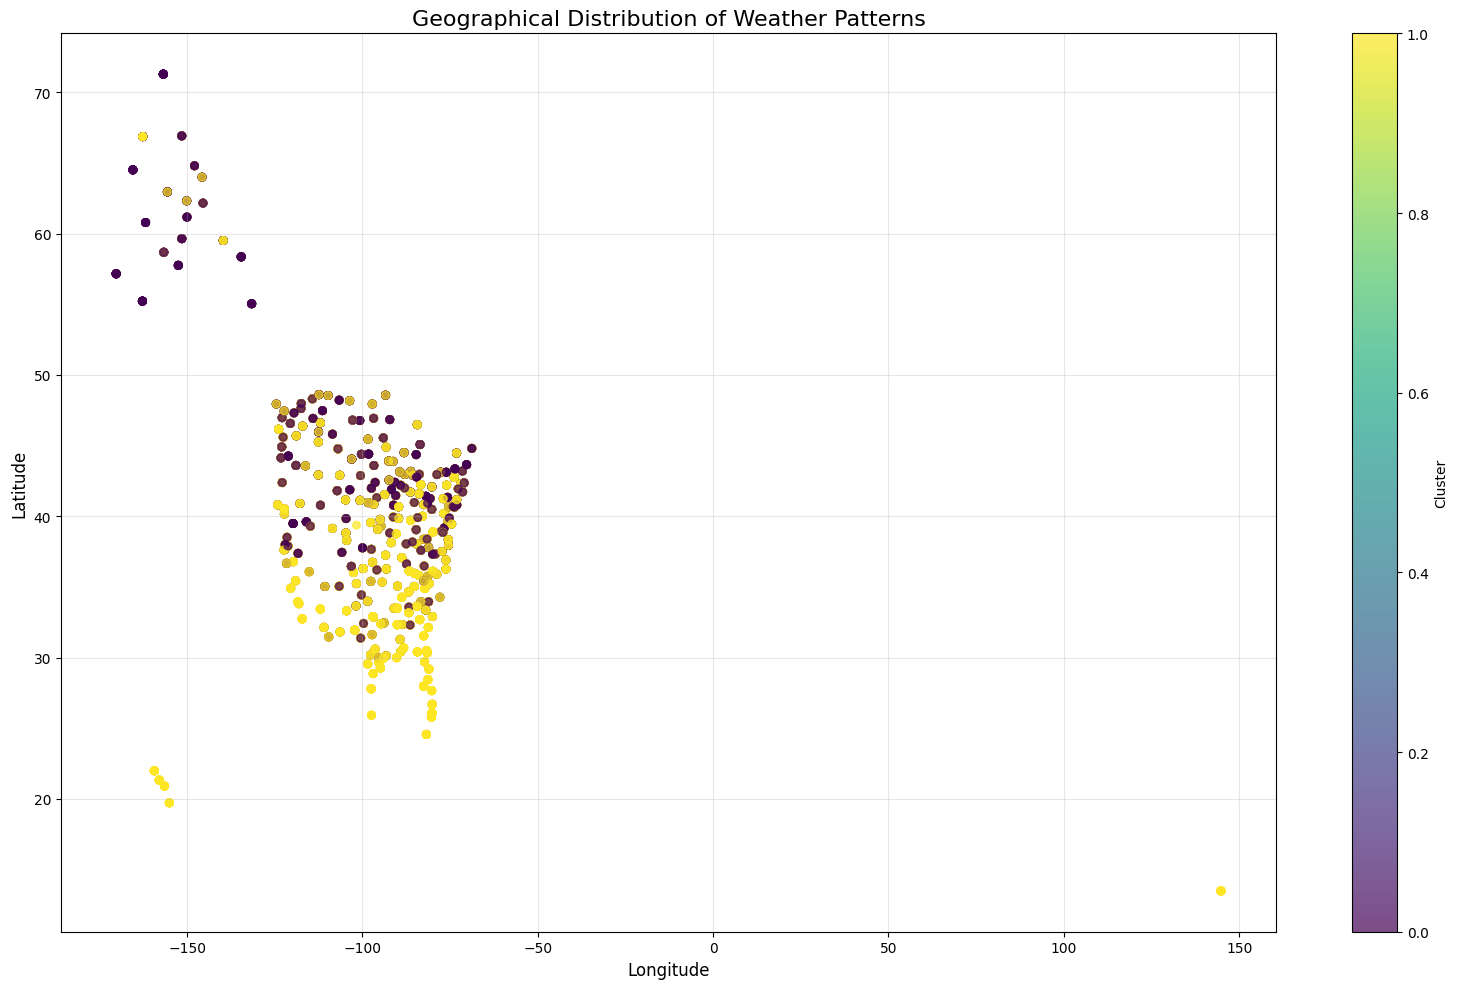

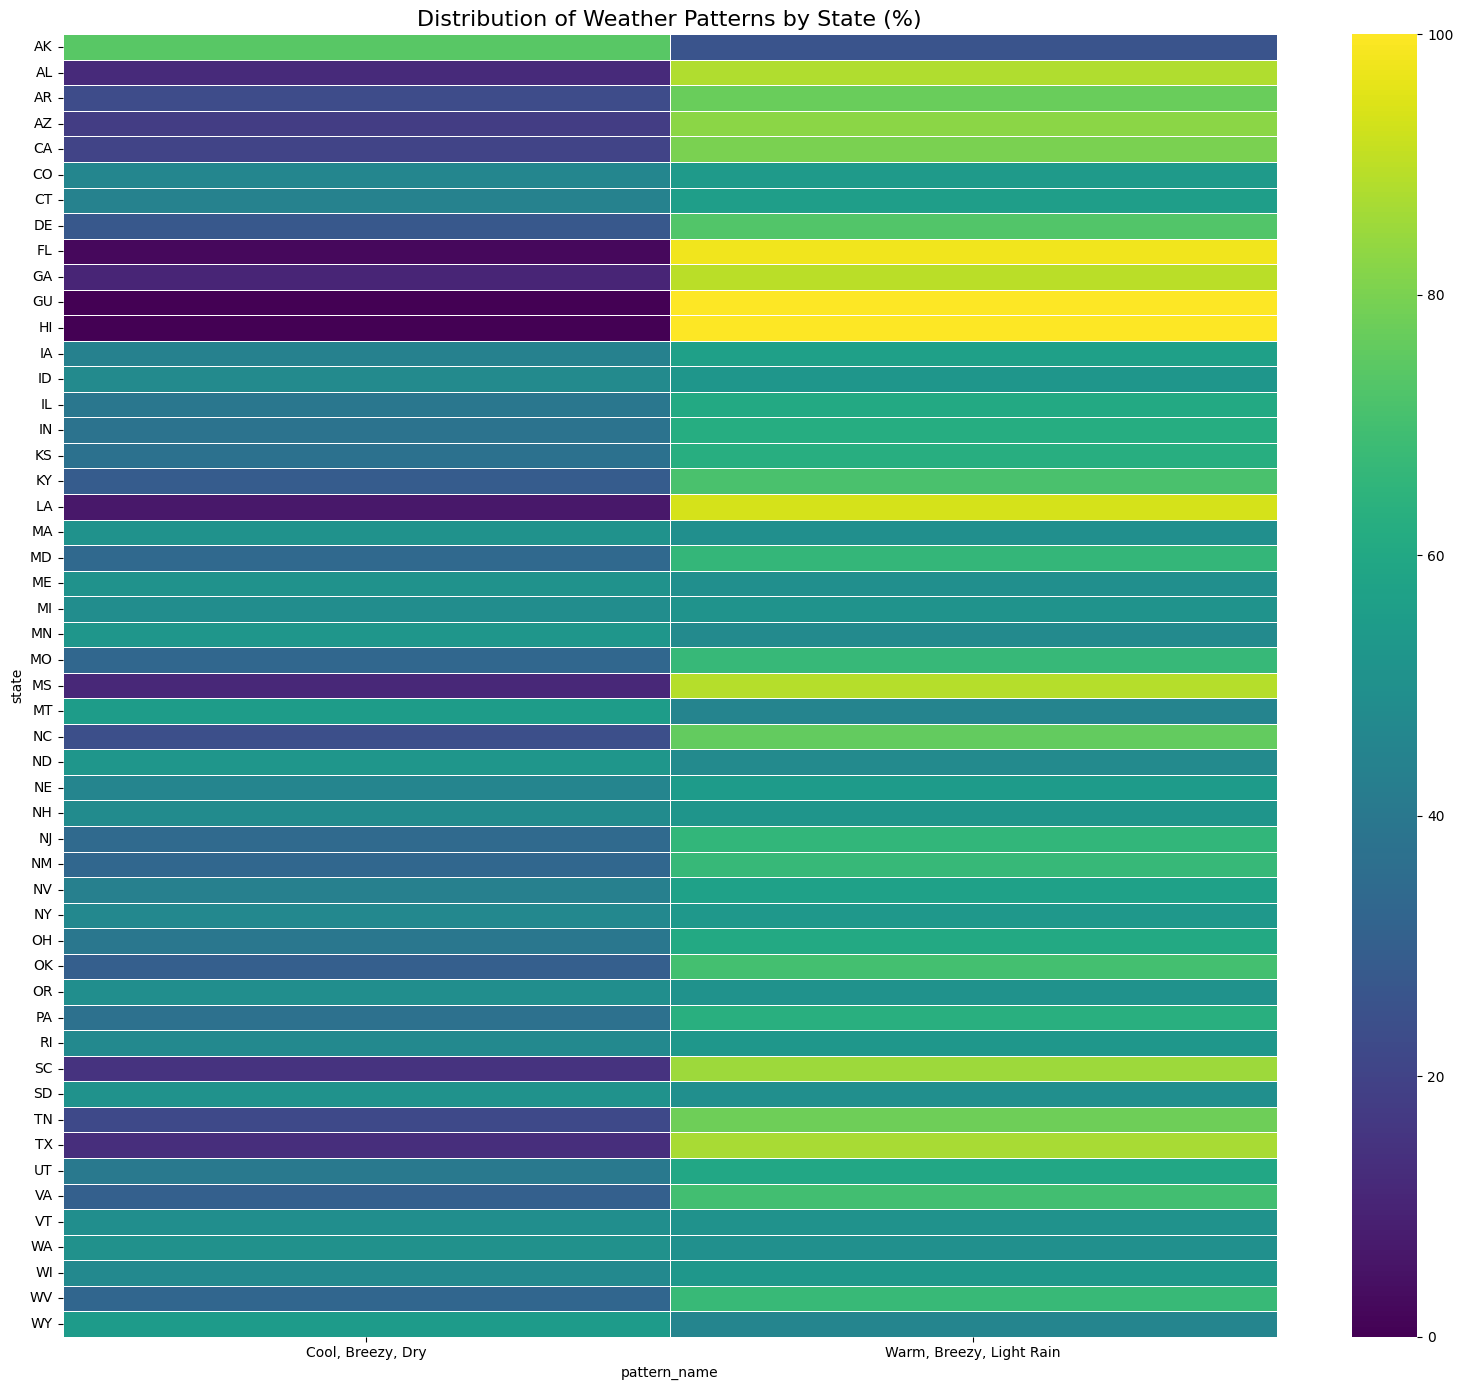

In [13]:
# 10. Geographical Distribution Analysis

# Create a simplified geographical visualization using matplotlib
print("\nAnalyzing geographical distribution of weather patterns")

# Sample data to avoid overplotting
sample_size = min(5000, len(complete_df))
geo_sample = complete_df.sample(sample_size)

# Create a scatter plot of locations colored by cluster
plt.figure(figsize=(16, 10))
scatter = plt.scatter(
    geo_sample['longitude'], 
    geo_sample['latitude'],
    c=geo_sample['cluster'], 
    cmap='viridis',
    alpha=0.7,
    s=30
)

# Add a colorbar legend
legend1 = plt.colorbar(scatter)
legend1.set_label('Cluster')

# Add title and labels
plt.title('Geographical Distribution of Weather Patterns', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('geographical_distribution.png')
plt.show()

# Analyze patterns by state
state_pattern_counts = pd.crosstab(
    complete_df['state'], 
    complete_df['pattern_name']
)

# Normalize to get percentage distribution of patterns within each state
state_pattern_pct = state_pattern_counts.div(state_pattern_counts.sum(axis=1), axis=0) * 100

# Plot state-pattern heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(
    state_pattern_pct, 
    annot=False, 
    cmap='viridis', 
    linewidths=0.5
)
plt.title('Distribution of Weather Patterns by State (%)', fontsize=16)
plt.tight_layout()
plt.savefig('state_cluster_distribution.png')
plt.show()

In [14]:
# 11. Save Results and Final Model

# Save the cluster model
from joblib import dump
dump(kmeans, 'weather_kmeans_model.joblib')

# Save the PCA model and scaler for future use
dump(optimizedPcaModel, 'weather_pca_model.joblib')
dump(featureScaler, 'weather_scaler.joblib')

# Save the cluster profiles
cluster_profiles.to_csv('weather_cluster_profiles.csv')

# Create and save a dataframe with pattern names and descriptions
pattern_df = pd.DataFrame({
    'cluster_id': list(range(1, optimal_k + 1)),
    'pattern_name': list(pattern_names.values()),
    'num_observations': [sum(cluster_labels == i) for i in range(optimal_k)]
})

for feature in selected_features:
    pattern_df[feature] = [cluster_profiles.loc[f'Cluster {i+1}', feature] for i in range(optimal_k)]

pattern_df.to_csv('weather_patterns.csv', index=False)
